# **Sales Meeting Notebook: Your Automated CRM Wingman** 📈
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/video-db/videodb-cookbook/blob/main/meeting_agent/Sales_Meeting_To_CRM.ipynb)

Meet Lauren, a sales executive at Nissan. Every day, she juggles calls, fields objections, highlights features, and convinces prospects to close deals. But after every intense negotiation, she still has to trudge through the painful task of logging details into the CRM manually.  

What if she could focus solely on winning the customer while an AI sidekick handled all the post-call admin work?  

With VideoDB, we can automate recording calls, extracting key points, summarizing the deal, and even pushing it directly into the CRM.  

Let’s build a smart sales sidekick that frees Lauren to do what she does best — sell!


### Install Dependencies

In [1]:
!pip -q install videodb

  Preparing metadata (setup.py) ... done


In [2]:
import os
from getpass import getpass

videodb_api_key = getpass("Please enter your VideoDB API Key: ")

os.environ["VIDEO_DB_API_KEY"] = videodb_api_key

Please enter your VideoDB API Key: ··········


In [3]:
from videodb import connect
conn = connect()

### Connect to the default collection

In [ ]:
coll = conn.get_collection()
print(coll)

#### We can also create a new meeting collection

In [ ]:
# coll = conn.create_collection(name ="Meeting Recorder", description = "This collection stores videos related to Meeting Recording Agent.")
# print(coll)

## Record the Sales Meeting — Fully Present, Zero Worries 🎙️🤝

Once connected, our AI wingman silently joins your sales meeting, records every second, and stores it safely in your collection.  

No need for frantic note-taking or scribbled follow-ups. Just focus on building trust and closing that deal — your AI buddy has your back.


In [ ]:
meeting = coll.record_meeting(
    meeting_url="https://meet.google.com/vai-pfyz-fjs",
    bot_name="VideoDB Sales Bot",
    meeting_title="Sales Call",
    callback_url="https://a1b2c3d4e5f6g7h8i9j0k1l2m3n4o5p7.m.pipedream.net",
)

### For the usecase demo, we have used a youtube video using the following snippet.

In [ ]:
# sales_video = coll.upload(url="https://www.youtube.com/watch?v=OVAMb6Kui6A")

### Real-time Updates

While the meeting unfolds, your bot can ping a callback URL with live status updates, so you always know what’s happening behind the scenes.  

Already have a recording? Simply fetch it by ID and dive straight into analysis mode.  


In [ ]:
sales_video = coll.get_video(video_id=meeting.video_id)
print(sales_video)

Video(id=m-z-0197e38f-efa6-70a1-bf0f-54af0294d81a, collection_id=c-6df474d9-3d39-419c-8d8e-604ab9c163db, stream_url=https://dseetlpshk2tb.cloudfront.net/v3/published/manifests/e57747ab-1106-4d66-88ef-1e4960832d74.m3u8, player_url=https://console.dev.videodb.io/player?url=https://dseetlpshk2tb.cloudfront.net/v3/published/manifests/e57747ab-1106-4d66-88ef-1e4960832d74.m3u8, name=Sales Call Example, description=None, thumbnail_url=None, length=122.69424)


## Transcribe and Index: Turning meetings into Structured Gold 🗣️💰

When the call wraps up, VideoDB works its magic: transcribing every word, tagging speakers, and marking timestamps.  

This turns a chaotic conversation into a clean, structured transcript — perfect for mining deal-critical insights.


In [ ]:
sales_video.index_spoken_words()
text_json = sales_video.get_transcript()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.40it/s]


### The meeting recorder stores a speaker timeline that indicates the exact timestamps when any speaker starts talking.

In [ ]:
# speaker_timeline = meeting.speaker_timeline
# print(speaker_timeline)

### For the usecase, we'll use this sample speaker timeline.

In [ ]:
speaker_timeline = [{"speaker_name": "Lauren", "start_time_seconds": 8.08}, {"speaker_name": "John", "start_time_seconds": 11.36}, {"speaker_name": "Lauren", "start_time_seconds": 13.92}, {"speaker_name": "John", "start_time_seconds": 16.079}, {"speaker_name": "Lauren", "start_time_seconds": 20.48}, {"speaker_name": "John", "start_time_seconds": 24.0}, {"speaker_name": "Lauren", "start_time_seconds": 26.69}, {"speaker_name": "John", "start_time_seconds": 27.41}, {"speaker_name": "Lauren", "start_time_seconds": 30.77}, {"speaker_name": "John", "start_time_seconds": 33.57}, {"speaker_name": "Lauren", "start_time_seconds": 37.41}, {"speaker_name": "John", "start_time_seconds": 38.69}, {"speaker_name": "Lauren", "start_time_seconds": 41.01}, {"speaker_name": "John", "start_time_seconds": 46.61}, {"speaker_name": "Lauren", "start_time_seconds": 58.67}, {"speaker_name": "John", "start_time_seconds": 74.99}, {"speaker_name": "Lauren", "start_time_seconds": 79.39}, {"speaker_name": "John", "start_time_seconds": 91.21}, {"speaker_name": "Lauren", "start_time_seconds": 92.33}, {"speaker_name": "John", "start_time_seconds": 102.41}, {"speaker_name": "Lauren", "start_time_seconds": 104.65}, {"speaker_name": "John", "start_time_seconds": 113.69}]


## Shape the Transcript into a Smooth Conversation 🪄💬

Raw transcripts are messy. Our formatter groups words into natural sentences and maps speaker labels (like "A", "B") to real names — making the call easy to read and ready for summaries or CRM updates.


In [ ]:
import json

def process_transcript(word_data, speaker_timeline):

    if not word_data:
        return []

    formatted_conversation_segments = []

    current_speaker_raw = None
    current_sentence_words = []
    current_sentence_begin = None
    current_sentence_end = None

    for entry in word_data:
        if not all(k in entry for k in ['speaker', 'text', 'start', 'end']):
            continue

        speaker = entry['speaker']
        word_text = entry['text']
        word_start_time = entry['start']
        word_end_time = entry['end']

        if current_speaker_raw is None or speaker != current_speaker_raw:
            if current_speaker_raw is not None and current_sentence_words:
                full_sentence_text = " ".join(current_sentence_words)
                formatted_conversation_segments.append({
                    "speaker": current_speaker_raw,
                    "start": current_sentence_begin,
                    "end": current_sentence_end,
                    "text": full_sentence_text
                })

            current_speaker_raw = speaker
            current_sentence_words = [word_text]
            current_sentence_begin = word_start_time
            current_sentence_end = word_end_time
        else:
            current_sentence_words.append(word_text)
            current_sentence_end = word_end_time

    if current_speaker_raw is not None and current_sentence_words:
        full_sentence_text = " ".join(current_sentence_words)
        formatted_conversation_segments.append({
            "speaker": current_speaker_raw,
            "start": current_sentence_begin,
            "end": current_sentence_end,
            "text": full_sentence_text
        })

    if not formatted_conversation_segments:
        return []

    processed_timeline = []
    for entry in speaker_timeline:
        speaker_name = entry.get("speaker_name")
        start_time_str = entry.get("start_time_seconds")

        if speaker_name and speaker_name != "Unknown Speaker" and start_time_str is not None:
            try:
                processed_timeline.append({
                    "start_time": float(start_time_str),
                    "speaker_name": speaker_name
                })
            except ValueError:
                pass

    processed_timeline.sort(key=lambda x: x["start_time"])

    final_transcript = []
    current_actual_speaker = "Unknown Speaker"
    timeline_idx = 0

    for segment in formatted_conversation_segments:
        segment_begin_time = segment.get("start")

        if not isinstance(segment_begin_time, (int, float)):

            final_transcript.append(segment.copy())
            continue

        while timeline_idx < len(processed_timeline) and \
              processed_timeline[timeline_idx]["start_time"] <= segment_begin_time:

            current_actual_speaker = processed_timeline[timeline_idx]["speaker_name"]
            timeline_idx += 1

        new_segment = segment.copy()
        new_segment["speaker"] = current_actual_speaker
        final_transcript.append(new_segment)

    return final_transcript

In [ ]:
named_transcript = process_transcript(text_json, speaker_timeline)
print(json.dumps(named_transcript, indent=2))

[
  {
    "speaker": "Lauren",
    "start": 8.08,
    "end": 11.28,
    "text": "Thank you for calling Nissan. My name is Lauren. Can I have your name?"
  },
  {
    "speaker": "John",
    "start": 11.36,
    "end": 12.96,
    "text": "Yeah, my name is John Smith."
  },
  {
    "speaker": "Lauren",
    "start": 13.92,
    "end": 15.52,
    "text": "Thank you, John. How can I help you?"
  },
  {
    "speaker": "John",
    "start": 16.079,
    "end": 20.16,
    "text": "I was just calling about to see how much it would cost to update the map in my car."
  },
  {
    "speaker": "Lauren",
    "start": 20.48,
    "end": 24.0,
    "text": "I'd be happy to help you with that today. Did you receive a mailer from us?"
  },
  {
    "speaker": "John",
    "start": 24.0,
    "end": 26.32,
    "text": "I did. Do you need the customer number?"
  },
  {
    "speaker": "Lauren",
    "start": 26.69,
    "end": 27.25,
    "text": "Yes, please."
  },
  {
    "speaker": "John",
    "start": 27.41,
    "en

### Let us create custom scenes based on our transcript and metadata

In [ ]:
from videodb.scene import Scene

scenes_with_metadata = []

for segment in named_transcript:
    scene = Scene(
        video_id=sales_video.id,
        start=segment.get('start', 0.0),
        end=segment.get('end', 0.0),
        description=segment.get('text', ''),
        metadata={"speaker": segment.get('speaker', 'Unknown')}
    )
    scenes_with_metadata.append(scene)
    
print(scenes_with_metadata)

[Scene(id=None, video_id=m-z-0197e38f-efa6-70a1-bf0f-54af0294d81a, start=8.08, end=11.28, frames=[], description=Thank you for calling Nissan. My name is Lauren. Can I have your name?), metadata={'speaker': 'Lauren'}), Scene(id=None, video_id=m-z-0197e38f-efa6-70a1-bf0f-54af0294d81a, start=11.36, end=12.96, frames=[], description=Yeah, my name is John Smith.), metadata={'speaker': 'John'}), Scene(id=None, video_id=m-z-0197e38f-efa6-70a1-bf0f-54af0294d81a, start=13.92, end=15.52, frames=[], description=Thank you, John. How can I help you?), metadata={'speaker': 'Lauren'}), Scene(id=None, video_id=m-z-0197e38f-efa6-70a1-bf0f-54af0294d81a, start=16.079, end=20.16, frames=[], description=I was just calling about to see how much it would cost to update the map in my car.), metadata={'speaker': 'John'}), Scene(id=None, video_id=m-z-0197e38f-efa6-70a1-bf0f-54af0294d81a, start=20.48, end=24.0, frames=[], description=I'd be happy to help you with that today. Did you receive a mailer from us?), 

#### 🧩 Index Scenes with Metadata  
Create scene segments enriched with transcript and speaker data — perfect for search & summarization.


In [ ]:
scene_index_id = sales_video.index_scenes(
    scenes=scenes_with_metadata,
    name="Scene indexing with speaker metadata and transcript"
)
print(scene_index_id)

d85b5faa2ae0b27e


In [7]:
scenes = sales_video.get_scene_index(scene_index_id)
print(scenes)

[{'description': 'Thank you for calling Nissan. My name is Lauren. Can I have your name?', 'end': 11.28, 'metadata': {}, 'scene_metadata': {'speaker': 'Lauren'}, 'start': 8.08}, {'description': 'Yeah, my name is John Smith.', 'end': 12.96, 'metadata': {}, 'scene_metadata': {'speaker': 'John'}, 'start': 11.36}, {'description': 'Thank you, John. How can I help you?', 'end': 15.52, 'metadata': {}, 'scene_metadata': {'speaker': 'Lauren'}, 'start': 13.92}, {'description': 'I was just calling about to see how much it would cost to update the map in my car.', 'end': 20.16, 'metadata': {}, 'scene_metadata': {'speaker': 'John'}, 'start': 16.079}, {'description': "I'd be happy to help you with that today. Did you receive a mailer from us?", 'end': 24.0, 'metadata': {}, 'scene_metadata': {'speaker': 'Lauren'}, 'start': 20.48}, {'description': 'I did. Do you need the customer number?', 'end': 26.32, 'metadata': {}, 'scene_metadata': {'speaker': 'John'}, 'start': 24.0}, {'description': 'Yes, please

#### 🔍 Find Key Interview Moments  
Ask your assistant to surface precise parts of the conversation, filtered by topic or speaker.


In [12]:
from videodb import IndexType, SearchType

speaker_result = sales_video.search(
    query="Show me where a discount is mentioned",
    index_type=IndexType.scene,
    search_type=SearchType.semantic,
    scene_index_id=scene_index_id,
    filter = [{'speaker': 'Lauren'}]
)

speaker_result.play()

## Summarize the Call and Auto-Generate CRM Details 🚀📄

Now for the real flex: we feed the structured conversation into an LLM that acts like your personal sales analyst.  

It extracts:
- Deal name
- Stage in the pipeline
- Deal amount
- Key description

The output is ready to push directly into your CRM, so you skip the typing and get straight to the next big win.


In [ ]:
import json

def get_sales_summary(conversation_string: str) -> dict | None:
    if not conversation_string:
        return None

    json_schema_string = json.dumps({
        "dealname": "The company or individual's name for the deal.",
        "dealstage": "The current stage of the deal. Possible values: 'appointmentscheduled', 'qualifiedtobuy', 'presentationscheduled', 'decisionmakerboughtin', 'contractsent', 'closedwon', 'closedlost'. Default to 'appointmentscheduled' if not clearly stated.",
        "amount": "The total monetary value of the deal as a number, encased as a string (e.g., '15000'). If not explicit, infer or state '0'.",
        "description": "A concise summary of the meeting, highlighting key takeaways or next steps discussed (max 200 words)."
    }, indent=4)

    SALES_ASSISTANT_PROMPT = f"""
You are an expert sales assistant. Your task is to analyze the following sales call transcript and provide a structured sales summary.

Extract the information for the following fields. All fields are mandatory.

Please provide the summary in the following JSON format. Ensure the output is ONLY the JSON object, with no additional text or conversational elements.

```json
{json_schema_string}
```

---
Transcript:
{conversation_string}
"""

    try:

        response = coll.generate_text(
            prompt=SALES_ASSISTANT_PROMPT,
            model_name="pro",
            response_type="json",
        )

        sales_summary_json = response
        return sales_summary_json

    except Exception:
        return None

In [ ]:
import json
conversation_string = json.dumps(named_transcript, indent=2)
sales_summary = get_sales_summary(conversation_string)
sales_summary_string = json.dumps(sales_summary, indent=2)
print(sales_summary_string)

{
  "output": {
    "amount": "99",
    "dealname": "John Smith",
    "dealstage": "closedwon",
    "description": "John Smith, a 2009 Nissan Altima owner, called to inquire about the cost of a map update after receiving a mailer. The representative, Lauren, quoted the update at $99 plus shipping and tax. John initially expressed hesitation about the price. Lauren successfully addressed his concern by pointing out that the update covered three years of changes and offered a limited-time $50 discount. Convinced by the value, John agreed to purchase the update and provided his Visa card details to complete the order during the call."
  }
}


## Push the Deal to HubSpot: From Call to Closed 📈🤝

With your summary prepared, it’s time to move it into your CRM seamlessly.  

Before proceeding, make sure you've integrated Composio with HubSpot:

1️⃣ Sign in to Composio and set up a new HubSpot integration.  
2️⃣ Authorize access to your deals pipeline.  
3️⃣ Grab the API key — we’ll need it for the final push.

Done? Great! Now watch as your AI sidekick updates HubSpot automatically, ensuring all important details are logged, without lifting a finger.


In [ ]:
!pip -q install composio

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 501.2/501.2 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.3/227.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 41.2 MB/s eta 0:00:00


In [ ]:
import os
from getpass import getpass

composio_api_key = getpass("Please enter your Composio API Key: ")

Please enter your Composio API Key: ··········


In [ ]:
import json
import os

from composio import ComposioToolSet, Action, App

toolset = ComposioToolSet(api_key=composio_api_key)

crm_data = sales_summary.get('output', sales_summary)

hubspot_action_create_deal = Action.HUBSPOT_CREATE_NEW_DEAL_OBJECT

deal_properties = {
    "dealname": crm_data.get("dealname"),
    "dealstage": crm_data.get("dealstage"),
    "amount": crm_data.get("amount"),
    "description": crm_data.get("description"),
    "pipeline": "default",
}

deal_properties = {k: v for k, v in deal_properties.items() if v is not None}

print("\n--- Sending Data to HubSpot via Composio ---")
print("Composio Params Payload:", json.dumps(deal_properties, indent=2))
try:
    response = toolset.execute_action(
        action=hubspot_action_create_deal,
        params=deal_properties,
    )

    if response and response.get('successful'):
        print(f"✅ Successfully sent data to HubSpot!")
        hubspot_deal_id = response.get('data', {}).get('id')
        if hubspot_deal_id:
            print(f"   New HubSpot Deal ID: {hubspot_deal_id}")
        print("   Composio Response Data:", json.dumps(response.get('data'), indent=2))
    else:
        print(f"❌ Failed to send data to HubSpot. Error: {response.get('error', 'Unknown error')}")
        print("   Composio Response (full):", json.dumps(response, indent=2))

except Exception as e:
    print(f"❌ An error occurred during Composio execution: {e}")

INFO:composio.utils.shared:Actions cache is outdated, refreshing cache...



--- Sending Data to HubSpot via Composio ---
Composio Params Payload: {
  "dealname": "John Smith",
  "dealstage": "closedwon",
  "amount": "99",
  "description": "John Smith, a 2009 Nissan Altima owner, called to inquire about the cost of a map update after receiving a mailer. The representative, Lauren, quoted the update at $99 plus shipping and tax. John initially expressed hesitation about the price. Lauren successfully addressed his concern by pointing out that the update covered three years of changes and offered a limited-time $50 discount. Convinced by the value, John agreed to purchase the update and provided his Visa card details to complete the order during the call.",
  "pipeline": "default"
}
✅ Successfully sent data to HubSpot!
   Composio Response Data: {
  "data": {
    "archived": false,
    "createdAt": "2025-07-10T13:52:06.569Z",
    "id": "116944533203",
    "properties": {
      "amount": "99",
      "amount_in_home_currency": "99",
      "closed_lost_reason": nul

### The sales detail has been populated in the Hubspot CRM

#### Before:
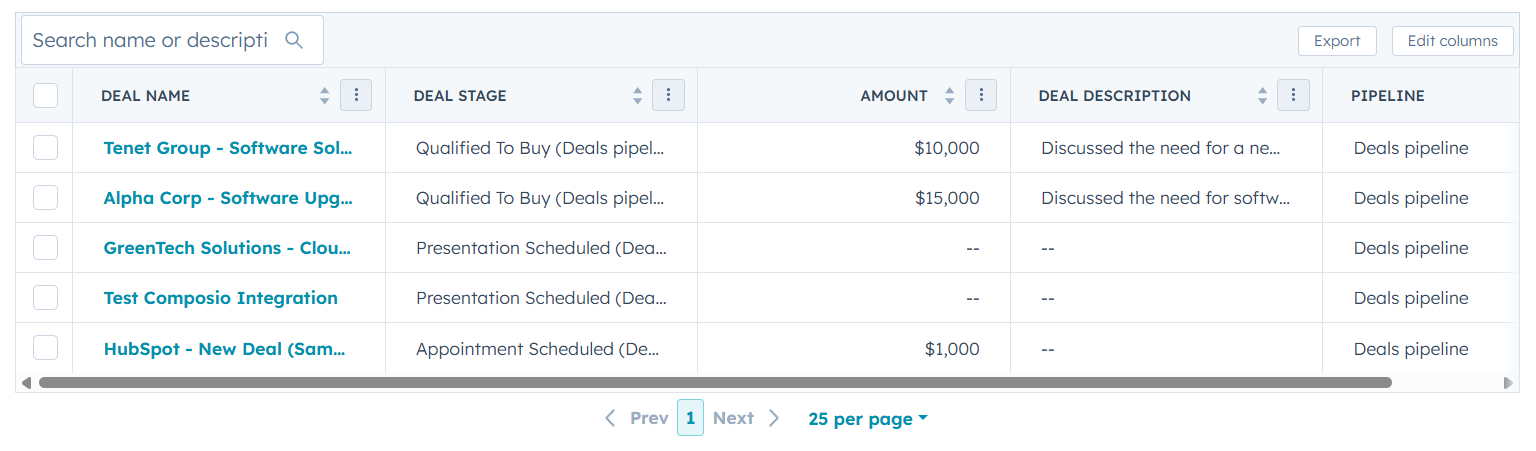

---

#### After:
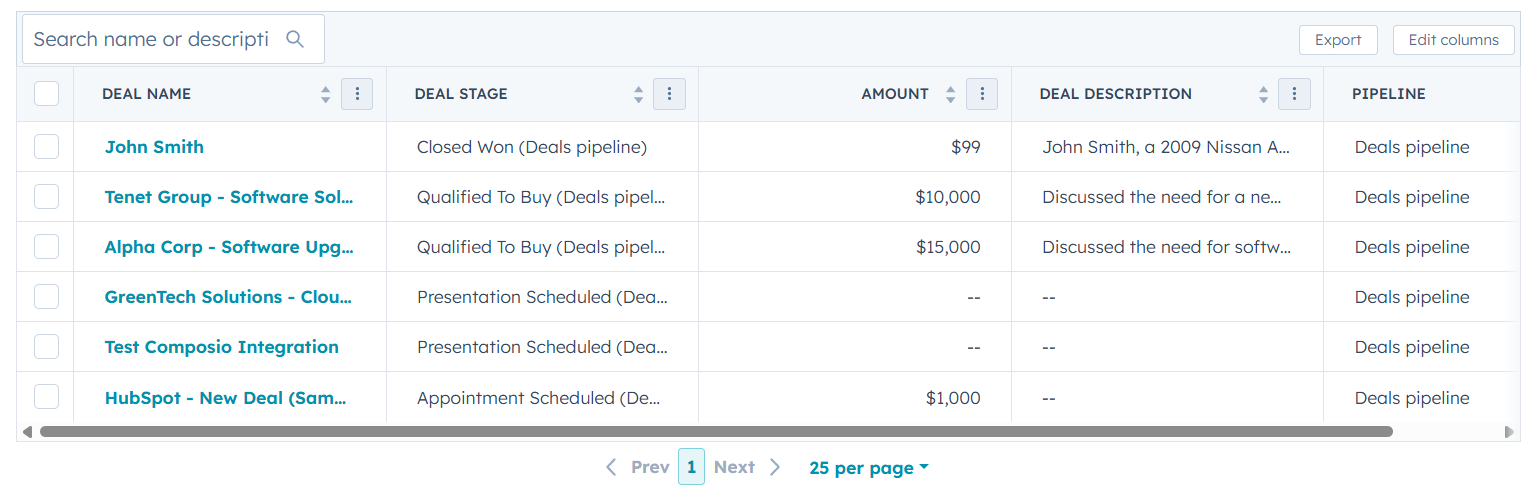

## And Just Like That… Your CRM Is Updated! 🎉🤖

Lauren can now jump to her next call without worrying about manual CRM updates or missing key details.

Our smart sales sidekick turns every meeting into a fully documented deal entry, complete with summaries, descriptions, and pipeline stages — all automatically.

But why stop there? Along with auto-updates, your new AI **director** actively assists during live calls — giving real-time suggestions on what questions to ask, how to handle objections, and how to close deals more confidently.

Imagine using these meeting insights to generate personalized follow-ups, schedule future tasks, suggest upsell opportunities, and now — even get on-the-spot coaching to boost your win rates.

With VideoDB’s powerful features, the possibilities are endless. So, what kind of AI sales sidekick will you build next?
